In [1]:
import sys
sys.path.append('./packages')
sys.path.append('./wrappers')
from dataset_wrapper import initialise_dataset

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.utils import set_determinism
from monai.data import Dataset, DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import torch
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# Modify to suit local machine
data_path = '../data/'

In [4]:
# Select what datatypes you would like to load from the dataset
# flair: Fluid-Attenuated Inversion Recovery. Highlights edema (swelling around tumor)
# t1: Standard T1-weighted scan. Good anatomical detail
# t1ce: T1-weighted with contrast enhancement. Shows areas where tumor enhances after injection of gadolinium
# t2: T2-weighted scan. Bright scan for fluids

modalities = ["flair", "t1", "t1ce", "t2"]

In [5]:
# DO NOT TOUCH
mod_dic = {}
for index, modality in enumerate(modalities):
    mod_dic[modality] = index

In [6]:
# This line should only every be ADDED to, and NOT subtracted from
# Import more functions if needed. Add them to transformations to apply them to data
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    ToTensord,
    AdjustContrastd,
    HistogramNormalized,
    NormalizeIntensityd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CenterSpatialCropd,
    SpatialPadd,
)

In [7]:
# Pre-processing. Add as many pre-processing transformations as you wish. Must be from monai
# IMPORTANT: Do not remove transformations outside the "Personal Transformations" section
transformations = Compose([
    LoadImaged(keys=["image", "seg_mask"]),  # loads NIfTI files
    EnsureChannelFirstd(keys=["image"]),
    EnsureChannelFirstd(keys="seg_mask"),
    EnsureTyped(keys="seg_mask", dtype=np.uint8),

# ----------------- Personal Transformations ----------------- #

    Orientationd(keys=["image", "seg_mask"], axcodes="RAS"),
    Spacingd(
        keys=["image", "seg_mask"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest")
    ),
    CenterSpatialCropd(keys=["image", "seg_mask"], roi_size=(160, 192, 160)),
    SpatialPadd(keys=["image","seg_mask"], spatial_size=(160,192,160)),  # pad to multiples of 16
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000, a_max=3000,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    HistogramNormalized(keys=["image"], num_bins=256),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    AdjustContrastd(keys=["image"], gamma=1.2),

# ------------------------------------------------------------ #

    ToTensord(keys=["image", "seg_mask"])  # convert both to torch tensors
])

C:\Users\vodou\miniconda3\envs\tumorsegmentation\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [8]:
# Initialises dataset that you can operate on
# Loads data DYNAMICALLY
dataset = initialise_dataset(data_path, modalities=modalities, transformations=transformations)

In [9]:
# Select Patient to observe
patient_id = 0
image, segmentation_mask = dataset.__getitem__(patient_id)
segmentation_mask = segmentation_mask[0]    # seg_mask has a channel dimension so need to remove it

In [10]:
# Select what MODALITY to visualise
modality = 'flair'
modality = mod_dic[modality]

image_selected_mod = image[modality,:,:,:]
image_selected_mod = image_selected_mod.squeeze(0)

In [11]:
slice_idx = 80  # pick any slice

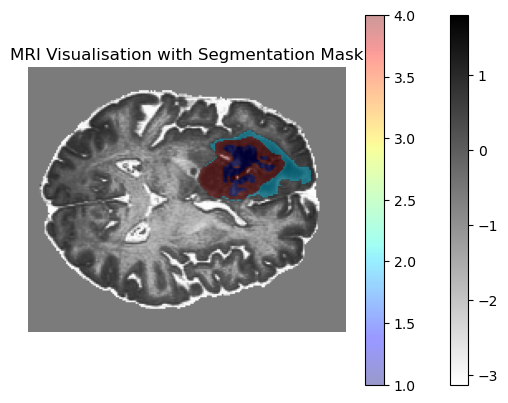

In [12]:
plt.imshow(image_selected_mod[:, :, slice_idx], cmap='gray_r')
#plt.imshow(image_selected_mod[:, :, slice_idx], cmap='gray')
plt.colorbar()
plt.imshow(np.ma.masked_where(segmentation_mask[:, :, slice_idx] == 0, segmentation_mask[:, :, slice_idx]), cmap='jet', alpha=0.4)
plt.colorbar()
plt.title("MRI Visualisation with Segmentation Mask")
plt.axis('off')
plt.show()

In [13]:
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
train_loader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=2)

In [21]:
# We will be comparing our 2d network to monai's 3d network (?)
model = UNet(
    spatial_dims=3,
    in_channels=4,       # MRI modalities
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

In [22]:
loss_function = DiceLoss(to_onehot_y=False, softmax=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [23]:
num_epochs = 50

img_idx = 0
mask_idx = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        inputs, labels = batch_data[img_idx].to(device), batch_data[mask_idx].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)           # logits
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


C:\Users\vodou\miniconda3\envs\tumorsegmentation\lib\site-packages\monai\losses\dice.py:160: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")


Epoch 1/50, Loss: -4.2071
Epoch 2/50, Loss: -1.4591


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "monai_3d_unet.pt")